# Generating plots for Bridge2021

In [2]:
from dsfunctions import forward_pass, forward_pass_nsteps, sample_windspeed, sample_winddirection, sample_geometry
from dsfunctions import plot_matrix, plot_matrix_ensemble, align_geoms, interpolate_geom, get_observation, plot_geometry
from dsfunctions import geom_to_vector, reproject_geom, validate_geom
from dsfunctions import forward_pass_farsite

import farsiteutils_v2 as futils
import datetime
import uuid

import numpy as np
from matplotlib import pyplot as plt

import contextily as ctx

import pickle
from shapely.geometry import Polygon
from tqdm import tqdm

/opt/conda/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Load data

In [3]:
description = 'Bridge2021'

# with open(f'./Bridge2021_results_22082024_vsz1_wsz100.pkl', 'rb') as f:
#     data = pickle.load(f)

# with open(f'./Bridge2021_results_22082024_vsz1_wsz1.pkl', 'rb') as f:
#     data = pickle.load(f)

with open(f'./Bridge2021_results_22082024_vsz100_wsz100.pkl', 'rb') as f:
    data = pickle.load(f)

# with open(f'./Bridge2021_results_22082024_vsz100_wsz1.pkl', 'rb') as f:
#     data = pickle.load(f)

# with open(f'./Bridge2021_results_22082024_vsz1000_wsz1.pkl', 'rb') as f:
#     data = pickle.load(f)



adjusted_geom_lst = data['adjusted_geom']
zkphat_ensemble_lst = data['zkphat_ensemble_lst']
xkphat_ensemble_lst = data['xkphat_ensemble_lst']
ykhat_ensemble_lst = data['ykhat_ensemble_lst']

tfin = 6



## Load the observations

In [4]:
# MAria Fire wind values
# Windspeed and Wind direction that were used live
# wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
# wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

# # # Bridge fire wind values
wslst = [15]*(tfin)
wdlst = [0]*(tfin)

# # River fire wind values
# wslst = [15]*(tfin)
# wdlst = [215]*(tfin)

observations = []
timestamps = []
sampled_wslst = []
sampled_wdlst = []

for tix in range(tfin):
    obs, ts = get_observation(description, tix)
    observations.append(obs)
    timestamps.append(ts)

## Generate estimated ignition

In [14]:
# Maria ignition
# ignition_timepoint = timestamps[0].replace(hour=18, minute=13)
# x,y = (-2084217.1484733422, 1503560.461310427)
# width = 200
# xshift = 2000
# yshift = 1500


# # Bridge2021 ignition
ignition_timepoint = timestamps[0].replace(hour=12, minute=53)
x,y = x,y = observations[0].centroid.x, observations[0].centroid.y
width = 100
xshift = -50
yshift = 50

# River2021 ignition
# ignition_timepoint = timestamps[0].replace(hour=14, minute=0)
# x,y = x,y = observations[0].centroid.x, observations[0].centroid.y
# width = 100
# xshift = -1200
# yshift = -2000

x += xshift
y+= yshift
ignition = Polygon([(x-width, y), (x, y), (x,y-width), (x-width, y-width)])

## Plot ignition + perimeters

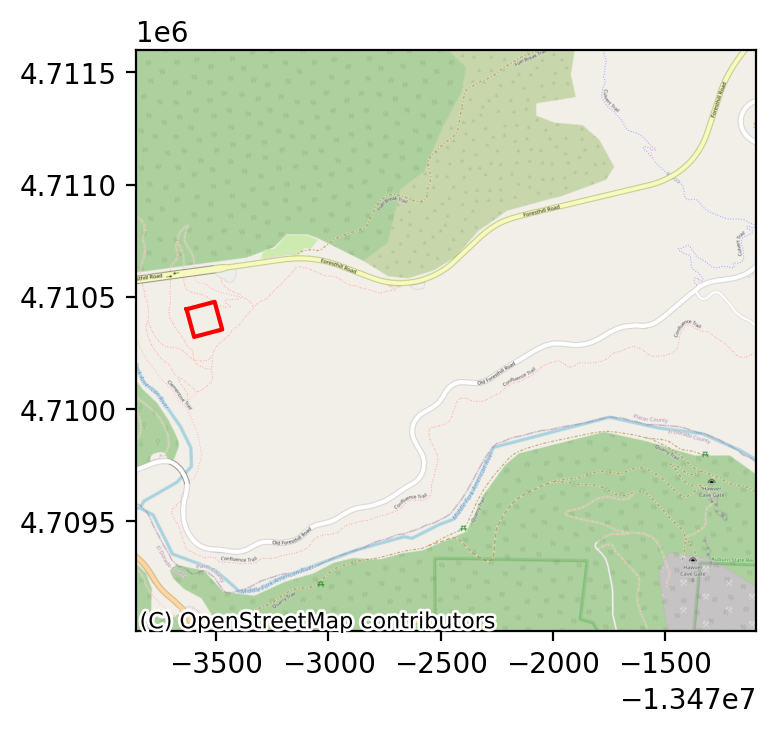

In [54]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(ignition), ax=ax, color='red')

for i in range(tfin):
    break    
    geom, timestamp = get_observation(description, i)
    plot_geometry(reproject_geom(geom), ax=ax, label=timestamp, color=(1,0,0,1-i/10))

    if i < (tfin-1):
        print(f'{timestamp - timestamps[0]}, {timestamps[i+1]-timestamps[i]}')
    else:
        print(f'{timestamp - timestamps[0]}')

    # break
# # Bridge boundaries
# # Bridge boundaries
ax.set_ylim((4709010.56092576, 4711600.804956875))
ax.set_xlim((-13473855.436906476, -13471093.057568321))


# # Maria boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

In [55]:
dt = timestamps[0] - ignition_timepoint

forward_geom = forward_pass_farsite(ignition, 
                                     params = {'windspeed': ws,
                                               'winddirection': wd,
                                               'dt': dt,
                                               'description': description})

/home/jovyan/farsite-devAPI/src/dsfunctions.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


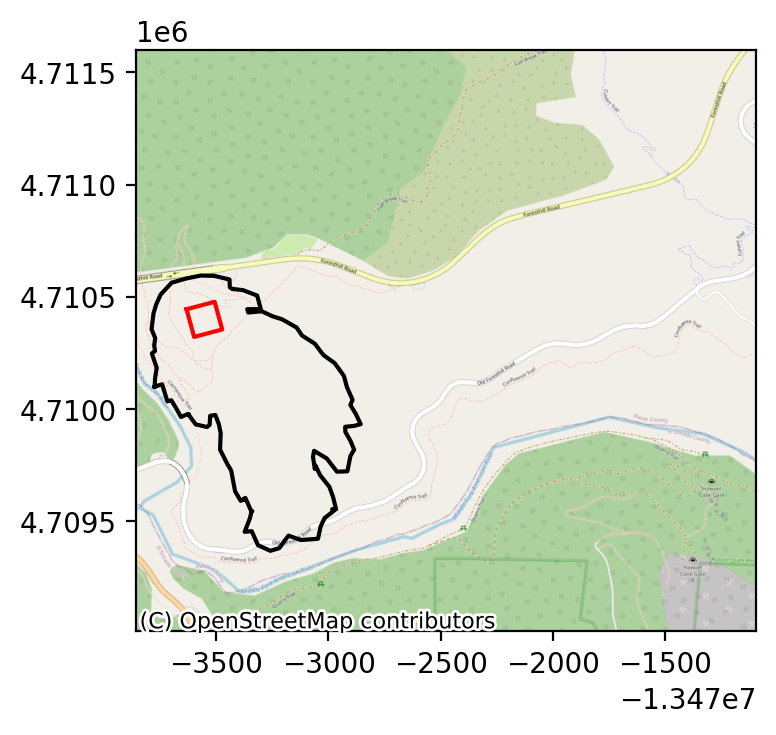

In [56]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(ignition), ax=ax, color='red')
plot_geometry(reproject_geom(forward_geom), ax=ax, label=timestamp, color=(0,0,0,1-i/10))

# # Bridge boundaries
ax.set_ylim((4709010.56092576, 4711600.804956875))
ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

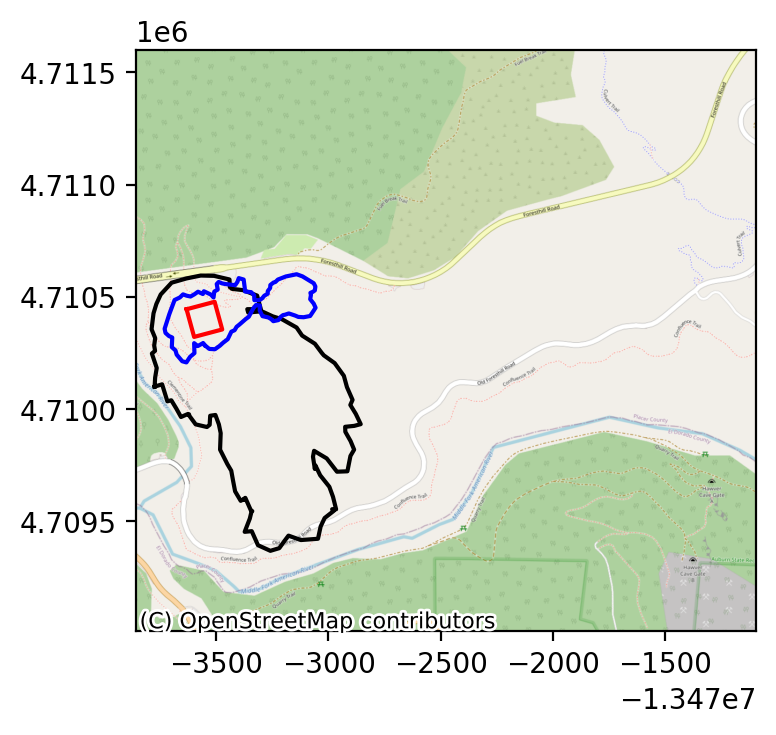

In [57]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(ignition), ax=ax, color='red')
plot_geometry(reproject_geom(forward_geom), ax=ax, label=timestamp, color=(0,0,0,1-i/10))
plot_geometry(reproject_geom(observations[0]), ax=ax, label=timestamp, color=(0,0,1,1-i/10))


# # Bridge boundaries
ax.set_ylim((4709010.56092576, 4711600.804956875))
ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

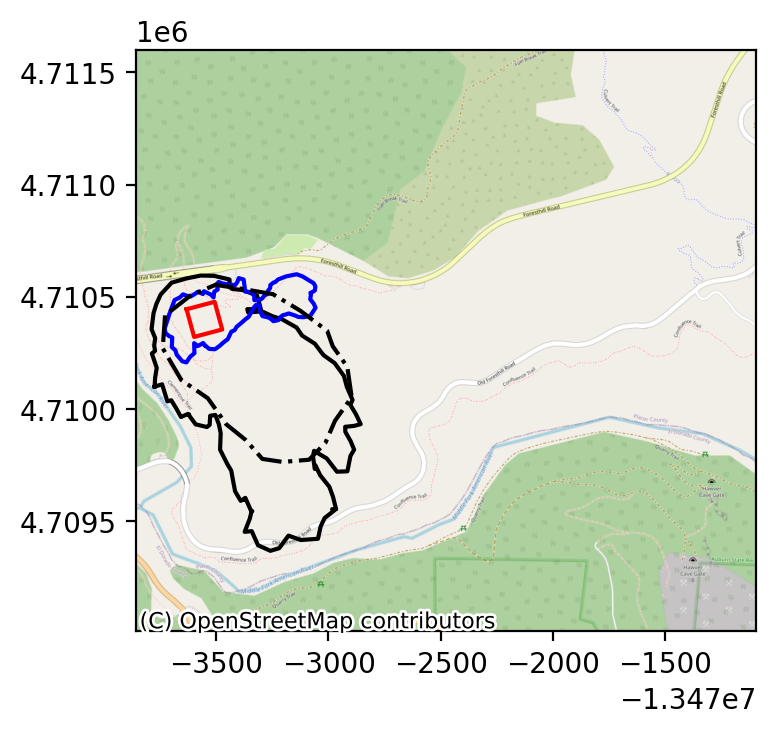

In [58]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(ignition), ax=ax, color='red')
plot_geometry(reproject_geom(forward_geom), ax=ax, label=timestamp, color=(0,0,0,1-i/10))
plot_geometry(reproject_geom(observations[0]), ax=ax, label=timestamp, color=(0,0,1,1-i/10))
plot_geometry(reproject_geom(adjusted_geom_lst[0]), ax=ax, label=timestamp, color=(0,0,0,1-i/10), ls='-.')


# # Bridge boundaries
ax.set_ylim((4709010.56092576, 4711600.804956875))
ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

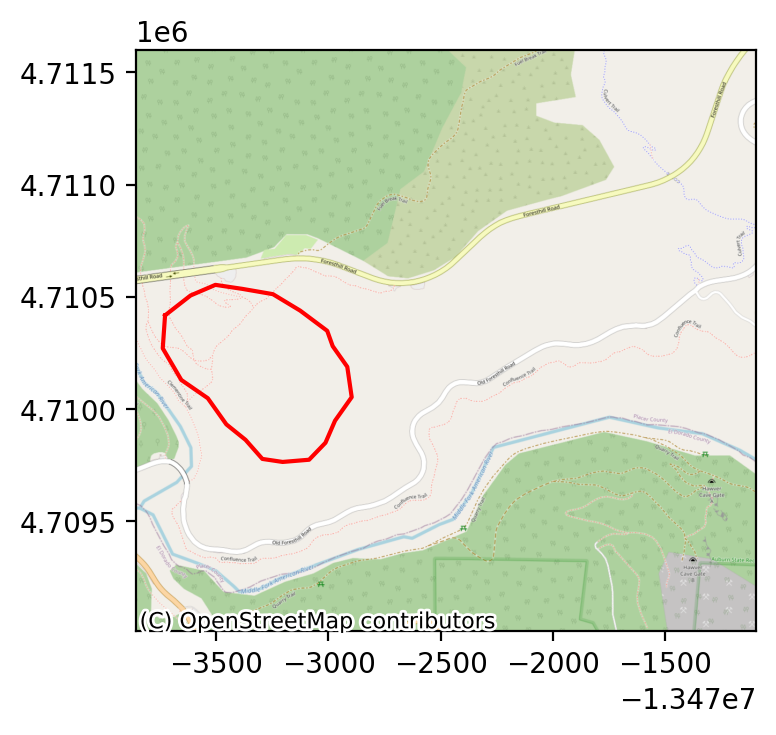

In [53]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(adjusted_geom_lst[0]), ax=ax, label=timestamp, color=(1,0,0,1-i/10))


# # Bridge boundaries
ax.set_ylim((4709010.56092576, 4711600.804956875))
ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

/home/jovyan/farsite-devAPI/src/dsfunctions.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


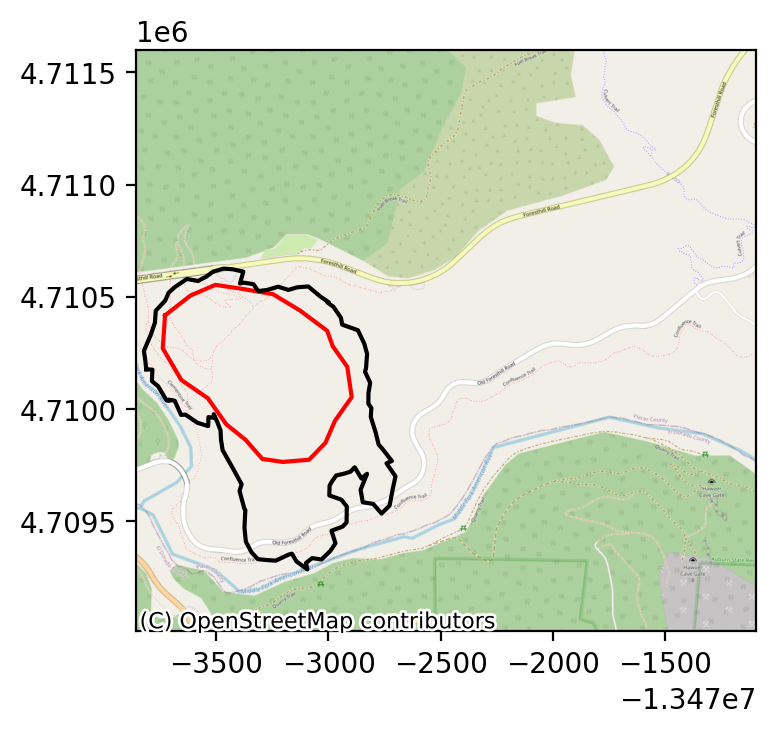

In [59]:
dt = timestamps[1] - timestamps[0]

forward_geom = forward_pass_farsite(adjusted_geom_lst[0], 
                                     params = {'windspeed': ws,
                                               'winddirection': wd,
                                               'dt': dt,
                                               'description': description})

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(adjusted_geom_lst[0]), ax=ax, label=timestamp, color=(1,0,0,1-i/10))
plot_geometry(reproject_geom(forward_geom), ax=ax, label=timestamp, color=(0,0,0,1-i/10))

# # Bridge boundaries
ax.set_ylim((4709010.56092576, 4711600.804956875))
ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

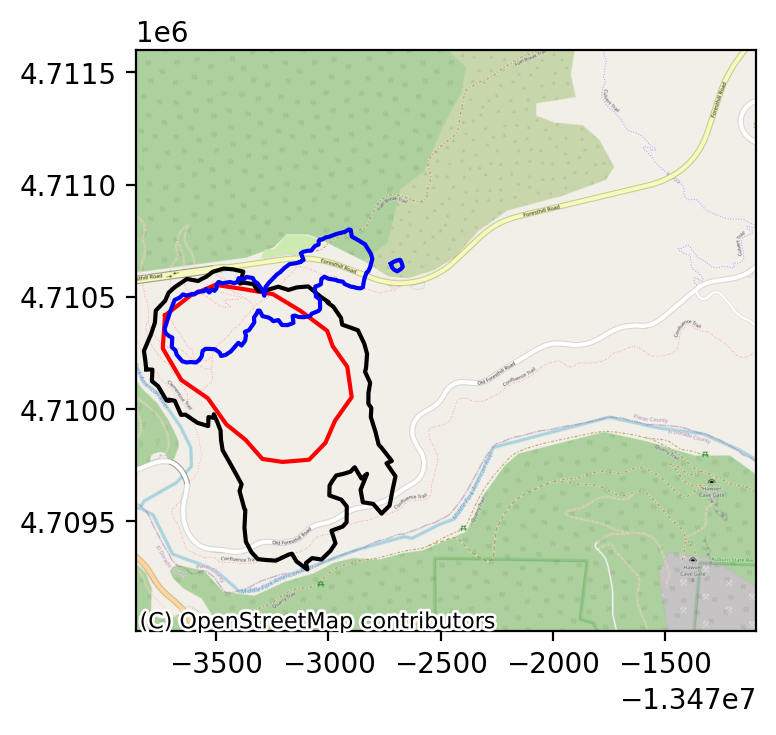

In [60]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(adjusted_geom_lst[0]), ax=ax, label=timestamp, color=(1,0,0,1-i/10))
plot_geometry(reproject_geom(forward_geom), ax=ax, label=timestamp, color=(0,0,0,1-i/10))
plot_geometry(reproject_geom(observations[1]), ax=ax, label=timestamp, color=(0,0,1,1-i/10))
# # Bridge boundaries
ax.set_ylim((4709010.56092576, 4711600.804956875))
ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

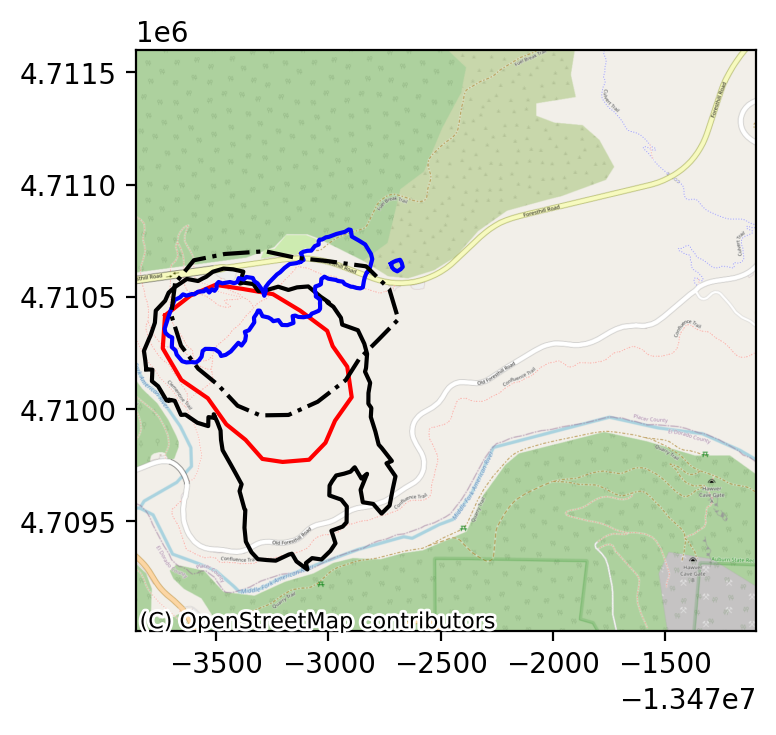

In [61]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(adjusted_geom_lst[0]), ax=ax, label=timestamp, color=(1,0,0,1-i/10))
plot_geometry(reproject_geom(forward_geom), ax=ax, label=timestamp, color=(0,0,0,1-i/10))
plot_geometry(reproject_geom(observations[1]), ax=ax, label=timestamp, color=(0,0,1,1-i/10))
plot_geometry(reproject_geom(adjusted_geom_lst[1]), ax=ax, label=timestamp, color=(0,0,0,1-i/10), ls='-.')
# # Bridge boundaries
ax.set_ylim((4709010.56092576, 4711600.804956875))
ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

## Calculate error of the farsite solutions after input adjustment

In [104]:
all_timestamps

[Timestamp('2021-09-05 12:53:52'),
 Timestamp('2021-09-05 14:04:52'),
 Timestamp('2021-09-05 14:34:29'),
 Timestamp('2021-09-05 15:02:16'),
 Timestamp('2021-09-05 15:25:20'),
 Timestamp('2021-09-05 15:58:27'),
 Timestamp('2021-09-05 16:23:31')]

In [105]:
adjusted_outputs = []

all_timestamps = [ignition_timepoint] + timestamps
all_ignitions = [ignition] + adjusted_geom_lst

for i in tqdm(range(len(all_timestamps)-1)):
    dt = all_timestamps[i+1] - all_timestamps[i]
    initial = all_ignitions[i]
    
    forward_geom = forward_pass_farsite(validate_geom(initial), 
                                     params = {'windspeed': ws,
                                               'winddirection': wd,
                                               'dt': dt,
                                               'description': description})

    adjusted_outputs.append(validate_geom(forward_geom))

  0%|          | 0/6 [00:00<?, ?it/s]/home/jovyan/farsite-devAPI/src/dsfunctions.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
 17%|█▋        | 1/6 [00:00<00:00,  8.34it/s]/home/jovyan/farsite-devAPI/src/dsfunctions.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
 33%|███▎      | 2/6 [00:00<00:00,  4.83it/s]/home/jovyan/farsite-devAPI/src/dsfunctions.py:391: SettingWithCopyWarning: 
A value is

In [106]:
def calculate_rms_state(state1, state2):
    return ((state1 - state2)**2).mean()
def calculate_area_diff_state(state1, state2):
    geom1 = Polygon(zip(state1[::2], state1[1::2]))
    geom2 = Polygon(zip(state2[::2], state2[1::2]))
    
    return (geom1.union(geom2) - geom1.intersection(geom2)).area
def align_states(state_lst, vertex_count=None):
    if vertex_count is None:
        vertex_count = max(len(st) for st in state_lst)//2
    x0 = state_lst[0][::2]
    y0 = state_lst[0][1::2]
    x1 = state_lst[1][::2]
    y1 = state_lst[1][1::2]

    geom0 = Polygon(zip(x0,y0))
    geom1 = Polygon(zip(x1,y1))

    geom0, geom1 = align_geoms([geom0, geom1], vertex_count)
    x,y = geom0.exterior.coords.xy
    x0 = x.tolist()[:-1]
    y0 = y.tolist()[:-1]
    state0 = xy_to_state(x0, y0)
    
    x,y = geom1.exterior.coords.xy
    x1 = x.tolist()[:-1]
    y1 = y.tolist()[:-1]
    state1 = xy_to_state(x1, y1)

    return [state0, state1]
    
def xy_to_state(x, y):
    ret = []
    for i in range(len(x)):
        ret.append(x[i])
        ret.append(y[i])

    return np.array(ret).reshape((2*len(x),1))

def state_to_xy(state):
    return state[::2], state[1::2]

def sample_xy(x,y, rng, scale=100):
    xs = rng.normal(x, scale=scale)
    ys = rng.normal(y, scale=scale)

    return xs,ys

In [116]:
adjusted_errors = []
no_adjusted_errors = []
for i in tqdm(range(6)):
    st_adj = geom_to_vector(validate_geom(adjusted_geom_lst[i]))
    st_obs = geom_to_vector(validate_geom(observations[i]))
    st_noadj = geom_to_vector(validate_geom(no_ds_outputs[i]))
    st1, st2 = align_states([st_obs, st_adj], vertex_count=1000)
    adjusted_errors.append(calculate_rms_state(st1, st2))

    st1, st2 = align_states([st_obs, st_noadj], vertex_count=1000)
    no_adjusted_errors.append(calculate_rms_state(st1, st2))

100%|██████████| 6/6 [00:00<00:00, 19.75it/s]


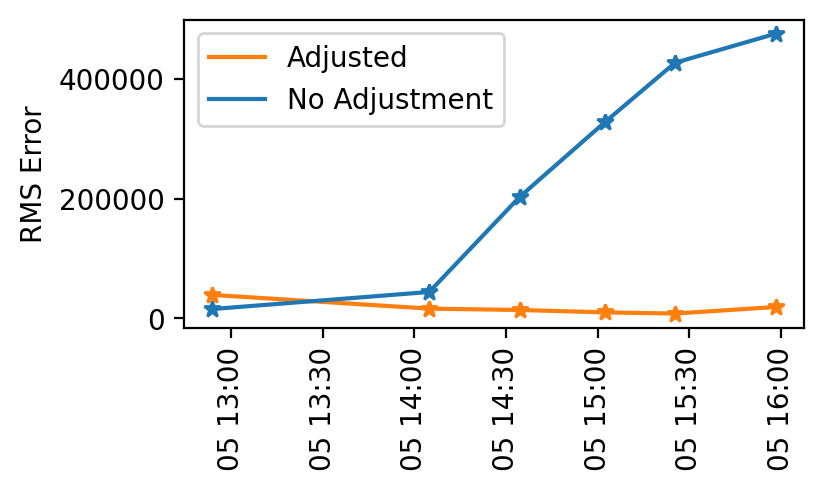

In [127]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
ax.plot(all_timestamps[:-1], adjusted_errors, label='Adjusted', color='tab:orange')
ax.plot(all_timestamps[:-1], adjusted_errors, '*', color='tab:orange')
ax.plot(all_timestamps[:-1], no_adjusted_errors, label='No Adjustment', color='tab:blue')
ax.plot(all_timestamps[:-1], no_adjusted_errors, '*', color='tab:blue')
ax.tick_params(axis='x', labelrotation=90)

ax.set_ylabel('RMS Error')
ax.legend()

In [88]:
ax.xaxis.l

## Model output without data assimilation

### Calculate

In [7]:
no_ds_outputs = [ignition]
for tix in tqdm(range(tfin-1)):
    ws = wslst[tix]
    wd = wdlst[tix]
    dt = timestamps[tix+1]-timestamps[tix]
    model_geom = forward_pass_farsite(no_ds_outputs[-1],
                                     params = {'windspeed': ws,
                                               'winddirection': wd,
                                               'dt': dt,
                                               'description': description})
    no_ds_outputs.append(model_geom)
    

  0%|          | 0/5 [00:00<?, ?it/s]/home/jovyan/farsite-devAPI/src/dsfunctions.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/home/jovyan/farsite-devAPI/src/dsfunctions.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
 40%|████      | 2/5 [00:00<00:00,  9.91it/s]/home/jovyan/farsite-devAPI/src/dsfunctions.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

## Plot model outputs

Text(0.5, 1.0, 'No data assimilation output')

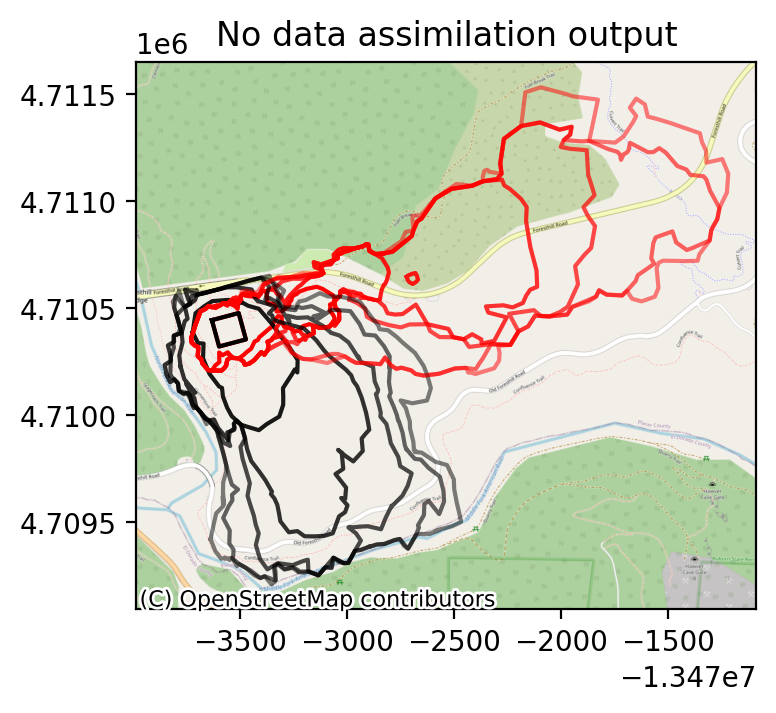

In [8]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(ignition), ax=ax, color='red')
for i in range(tfin):
    model_geom = no_ds_outputs[i]
    plot_geometry(reproject_geom(model_geom), ax=ax, label=timestamp, color=(0,0,0,1-i/10))
        
    geom, timestamp = get_observation(description, i)
    plot_geometry(reproject_geom(geom), ax=ax, label=timestamp, color=(1,0,0,1-i/10))

    adjusted_geom = adjusted_geom_lst[i]
    # plot_geometry(reproject_geom(adjusted_geom), ax=ax, label=timestamp, color=(0,0,1,1-i/10), ls='--', lw=1)

# Maria boundaries
# ax.set_xlim(-13259480.899793554, -13248356.055776488)
# ax.set_ylim(4066612.9682816155, 4075471.350794237)

# # Bridge boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('No data assimilation output')

Text(0.5, 1.0, 'With data assimilation')

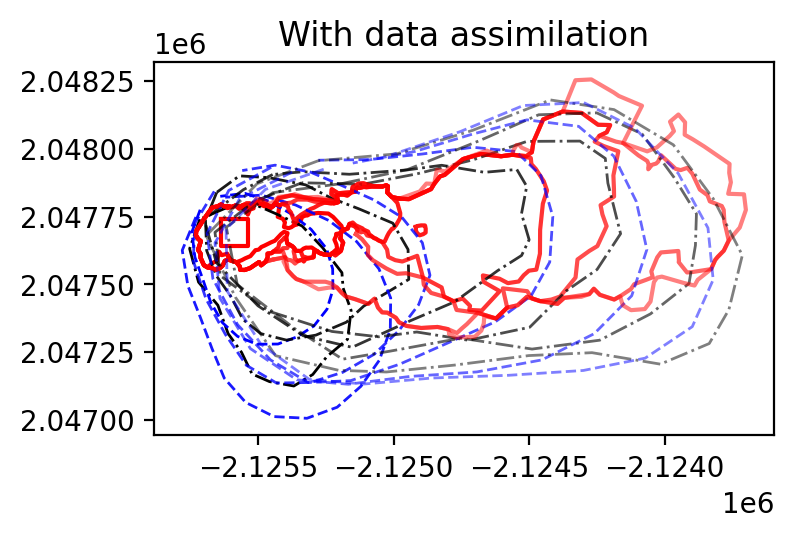

In [9]:
wdlstfig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(ignition, ax=ax, color='red')
for i in range(tfin):
    # model_geom = no_ds_outputs[i]
    # plot_geometry(reproject_geom(model_geom), ax=ax, label=timestamp, color=(0,0,0,1-i/10))
        
    geom, timestamp = get_observation(description, i)
    plot_geometry(geom, ax=ax, label=timestamp, color=(1,0,0,1-i/10))

    adjusted_geom = adjusted_geom_lst[i]
    xkphat_ensemble = xkphat_ensemble_lst[i]
    plot_geometry(adjusted_geom, ax=ax, label=timestamp, color=(0,0,0,1-i/10), ls='-.', lw=1)
    # plot_matrix(xkphat_ensemble, ax=ax, color=(0,0,0,1-i/10), ls='--', lw=1)

    zkphat_ensemble = zkphat_ensemble_lst[i]
    plot_matrix(zkphat_ensemble, ax=ax, color=(0,0,1,1-i/10), ls='--', lw=1)
# Maria boundaries
# ax.set_xlim(-13259480.899793554, -13248356.055776488)
# ax.set_ylim(4066612.9682816155, 4075471.350794237)

# # Bridge boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('With data assimilation')